<h1> How to do NLP-like research in physics


This notebook provides a step-by-step demonstration/tutorial based on the Lagrangian paper.

# Acknowledge SUPR

The computations and data handling were enabled by resources provided by the National Academic Infrastructure for Supercomputing in Sweden (NAISS) from projects ????, partially funded by the Swedish Research Council through grant agreement no. 2022-06725

# Libraries

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import random 


2025-04-09 11:22:51.242918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 11:22:51.285930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 11:22:52.253318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Checking Tokens Format
particle_id_token          :  ['ID1']
derivative_id_token        :  ['ID1']
gamma_id_token             :  ['ID1']
sigma_id_token(1)          :  ['ID1']
spin_token(0)              :  ['SPIN', '0']
spin_token(1)              :  ['SPIN', '1']
spin_token(Fraction(1,2))  :  ['SPIN', '1/2']
helicity_token(1)          :  ['HEL', '1/2']
helicity_token(-1)         :  ['HEL', '-1/2']
group_tokens(1)            :  ['U1']
group_tokens(1,test)            :  ['U1', '_{test}']
group_tokens(2)            :  ['SU2']
group_tokens(2,test)            :  ['SU2', '_{test}']
group_tokens(3)            :  ['SU3']
group_tokens(3,test)            :  ['SU3', '_{test}']
Tokens Format OK


# Models
- Overview of HuggingFace library.
- How to find off-the-shelf transformer models (e.g., BART-L).
- Example usage of a HuggingFace model.

## HuggingFace Library

In [2]:
# # Import HuggingFace libraries
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# # Load a pre-trained model and tokenizer (e.g., BART-small)
# # Note: You can change the model name to any other Seq2Seq model available on HuggingFace
# # Model name can be changed to any other Seq2Seq model available on HuggingFace
# # For example: 'facebook/bart-base', 't5-small', etc.

# # 'facebook/bart-base' : BART model with 140M parameters
# # 'facebook/bart-large' : BART model with 406M parameters
# # 't5-small' : T5 model with 60M parameters

# model_name = 'facebook/bart-base'
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Example usage
# text = "This is a sample input."
# inputs = tokenizer(text, return_tensors="pt")
# outputs = model.generate(**inputs)
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

# Dataset
- Discussion on data generation considerations:
  - Data distribution.
  - Tokenization choices.
- Example of tokenizing a dataset.

## Data Distribution


Show plots from paper:
- one from random ->  more equal better at long expression
- one from smart  ->  more biased (cover edge terms) better at special cases

In [ ]:
sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")


In [5]:
sampled_df["nfields"] = sampled_df["fields"].apply(lambda x: x.count("FIELD"))
sampled_df["nfermions"] = sampled_df["fields"].apply(lambda x: x.count("SPIN 1"))
sampled_df["nscalars"] = sampled_df["fields"].apply(lambda x: x.count("SPIN 0"))

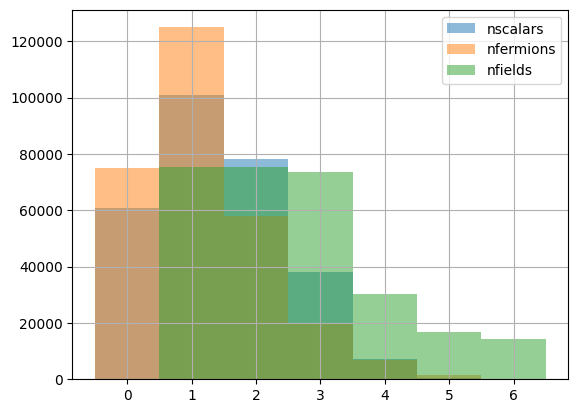

In [ ]:
sampled_df["nscalars"].hist(  range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nscalars") 
sampled_df["nfermions"].hist( range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nfermions") 
sampled_df["nfields"].hist(   range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nfields") 
plt.legend()

## Tokenization choices
Considerations: 
- What information is required for your model to learn?
- Do you care about expressivity? 

Practical 
- How much information?
- Vocabulary Size?

### Choices of Tokenization

In Language:
Example Phrase : AI For Physics
- Word-Level : AI, For, Physics
- Character-Level : A, I,  , F, o, r,  , P, h, y, s, i, c, s

In Math:
Example Expression : 100 + 420 = 520
- "Term"-level : 100, +, 420, =, 520
- "Digit"-Level : 1, 0, 0,  +,  4, 2, 0, =,  5, 2, 0

In Lagrangians:
Example Field : Higgs Particle
- Symbol Level : H
- Quantum-Numbers-Level: FIELD, SPIN, 0, SU2, 2, U1, 1



Remark: 
1. Detailed tokenization : 
- less vocabulary
- more expressive
- more token per sequence
- heavy on attention mechanism
2. Coarse tokenization : 
- more vocabulary
- less expressive
- less token per sequence
- easier on attention mechanism

### Example : Math 

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Character-level 
# 1. Generate arithmetic corpus
char_level_corpus = [" ".join(list(f"{a}+{b}={str(a + b)}")) for a in range(100) for b in range(100)]
vocab = {"1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9,
         "0" : 0, "+" : 10, "=" : 11,"[UNK]" : 12, "[PAD]" : 13, "[BOS]" : 14, "[EOS]" : 15}
# 2. Initialize tokenizer components
char_level_tokenizer = Tokenizer(WordLevel(vocab=vocab, unk_token="[UNK]"))
char_level_tokenizer.pre_tokenizer = Whitespace()


# Word-level 
word_level_corpus = [f"{a} + {b} = {str(a + b)}" for a in range(100) for b in range(100)]
word_level_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
word_level_tokenizer.pre_tokenizer = Whitespace()
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
trainer = WordLevelTrainer(special_tokens=special_tokens)
word_level_tokenizer.train_from_iterator(word_level_corpus, trainer)



lets see it in action

In [8]:
char_level_example = random.choice(char_level_corpus)
print("char_level_example : ",char_level_example)
print("char_level_tokens  : ",char_level_tokenizer.encode(char_level_example).tokens,end="\n\n")

word_level_example = random.choice(word_level_corpus)
print("word_level_example : ",word_level_example)
print("word_level_tokens  : ",word_level_tokenizer.encode(word_level_example).tokens,end="\n\n")

char_level_example :  2 7 + 2 8 = 5 5
char_level_tokens  :  ['2', '7', '+', '2', '8', '=', '5', '5']

word_level_example :  27 + 99 = 126
word_level_tokens  :  ['27', '+', '99', '=', '126']



Lets check vocab size

In [9]:
print("char_level_vocab_size: ",char_level_tokenizer.get_vocab_size())
print("word_level_vocab_size: ",word_level_tokenizer.get_vocab_size())

char_level_vocab_size:  16
word_level_vocab_size:  205


Try encoding 10000

In [10]:
OOD_char_level_example =   "1 0 0 0 0"
print("char_level_tokens  : ",char_level_tokenizer.encode(OOD_char_level_example).tokens,end="\n\n")

OOD_word_level_example =   "10000"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

# Something like this is possible but not intuitive (words and number are slightly different)
OOD_word_level_example =   "10 0 0 0"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

char_level_tokens  :  ['1', '0', '0', '0', '0']

word_level_tokens  :  ['[UNK]']

word_level_tokens  :  ['10', '0', '0', '0']



### Example : Fields 

In [11]:
from transformers import  PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast.from_pretrained("JoseEliel/BART-Lagrangian")

example = sampled_df.sample(1)["fields"].values[0]
print("Input    = ",example)
encoded = hf_tokenizer.encode(example)
print("token_id = ", encoded)
decoded = hf_tokenizer.decode(encoded)
print("decoded  = ", decoded)


Input    =  FIELD SPIN 1/2 SU3 3 U1 - 2 / 7 HEL -1/2
token_id =  [22, 36, 5, 4, 6, 38, 10, 39, 7, 6, 4, 14, 23, 7, 5, 4, 6]
decoded  =  FIELD SPIN 1 / 2 SU3 3 U1 - 2 / 7 HEL - 1 / 2


#### TAKEAWAY : THe level of tokenization affects attention usage and vocab size

# Training
- Mention available resources: SUPR/NAISS -> Alvis.
- Example of training a model.

### NAISS : https://www.naiss.se/
### SUPR : https://supr.naiss.se/
### Alvis : https://www.c3se.chalmers.se/about/Alvis/
### OnDemand Portal : https://alvis.c3se.chalmers.se/pun/sys/dashboard/

## CPU or GPU

In [31]:
# Choose GPU if available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Evaluation
- Generating output from the model.
- Discussion on evaluation choices:
  - Existing or novel metrics.
  - Embedding analysis.
  - Out-of-distribution tests.

## Existing Metric  : Does it work? 

mainly to see if things work as expected
Loss : Deviation from actual term 
Accuracy : How much is perfect? 
New metric, Score : (Order does not always matter, XEN)

In [ ]:
import lag_eval as le
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# Load our BART-L model and tokenizer if not yet loaded
model_name = "JoseEliel/BART-Lagrangian"
model = BartForConditionalGeneration.from_pretrained(model_name)
#hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)


2025-04-09 13:37:45.451926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 13:37:45.578289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 13:37:46.769057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Checking Tokens Format
particle_id_token          :  ['ID1']
derivative_id_token        :  ['ID1']
gamma_id_token             :  ['ID1']
sigma_id_token(1)          :  ['ID1']
spin_token(0)              :  ['SPIN', '0']
spin_token(1)              :  ['SPIN', '1']
spin_token(Fraction(1,2))  :  ['SPIN', '1/2']
helicity_token(1)          :  ['HEL', '1/2']
helicity_token(-1)         :  ['HEL', '-1/2']
group_tokens(1)            :  ['U1']
group_tokens(1,test)            :  ['U1', '_{test}']
group_tokens(2)            :  ['SU2']
group_tokens(2,test)            :  ['SU2', '_{test}']
group_tokens(3)            :  ['SU3']
group_tokens(3,test)            :  ['SU3', '_{test}']
Tokens Format OK


In [ ]:
# Load data if not already loaded, drop duplicates
#sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")
sampled_df.drop_duplicates(subset=["fields"], inplace=True)

In [4]:
sampled_df

,fields,Lagrangian,train/eval
0,FIELD SPIN 1/2 SU3 - 3 SU2 2 U1 - 4 HEL 1/2 FI...,+ FIELD SPIN 1 / 2 SU3 - 3 SU2 2 HEL - 1 / 2 D...,eval
1,FIELD SPIN 1/2 HEL 1/2 FIELD SPIN 1/2 SU3 - 3 ...,+ i FIELD SPIN 1 / 2 HEL 1 / 2 ID9 SIGMA_BAR I...,eval
2,FIELD SPIN 0 SU2 3 U1 - 4 / 9 FIELD SPIN 1/2 S...,+ FIELD SPIN 0 SU2 3 U1 - 4 / 9 ID1 FIELD SPIN...,eval
3,FIELD SPIN 1/2 SU3 - 3 U1 3 / 8 HEL -1/2 FIELD...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 8 / 9 ID3 FI...,eval
4,FIELD SPIN 0 SU3 3 SU2 3,+ FIELD SPIN 0 SU3 3 SU2 3 ID4 FIELD SPIN 0 SU...,eval
...,...,...,...
286076,FIELD SPIN 0 SU3 3 SU2 3 U1 9 / 2 FIELD SPIN 1...,+ FIELD SPIN 1 / 2 SU2 2 U1 1 / 5 HEL - 1 / 2 ...,train
286077,FIELD SPIN 0 FIELD SPIN 0 SU3 3 SU2 3 U1 7 / 6...,+ FIELD SPIN 0 ID1 FIELD SPIN 0 SU3 3 SU2 3 U1...,train
286078,FIELD SPIN 0 SU3 - 3 U1 3 FIELD SPIN 1/2 SU3 3...,+ FIELD SPIN 0 SU3 - 3 U1 3 ID4 FIELD SPIN 0 S...,train
286079,FIELD SPIN 1/2 U1 - 4 / 5 HEL -1/2 FIELD SPIN ...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 / 7 ID6 FI...,train


### Example : Lagrangian Score

Choose a random lagrangian to work with

In [5]:
example_scenario = sampled_df.sample(1)


Look at the input (field content)

In [6]:
example = example_scenario["fields"].values[0]
example_input = "[SOS] " + example + " [EOS]"
print("Input    = ",example_input)
encoded_input = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)
decoded_input = hf_tokenizer.decode(encoded_input)
print("decoded  = ", decoded_input)


Input    =  [SOS] FIELD SPIN 0 SU2 2 U1 1 / 4 FIELD SPIN 1/2 SU3 - 3 SU2 3 U1 3 / 4 HEL -1/2 FIELD SPIN 0 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 FIELD SPIN 0 SU3 - 3 U1 5 / 7 [EOS]
token_id =  [0, 22, 36, 9, 37, 6, 39, 5, 4, 11, 22, 36, 5, 4, 6, 38, 7, 10, 37, 10, 39, 10, 4, 11, 23, 7, 5, 4, 6, 22, 36, 9, 22, 36, 9, 38, 10, 37, 6, 39, 14, 4, 6, 22, 36, 9, 38, 7, 10, 39, 12, 4, 14, 1]
decoded  =  [SOS] FIELD SPIN 0 SU2 2 U1 1 / 4 FIELD SPIN 1 / 2 SU3 - 3 SU2 3 U1 3 / 4 HEL - 1 / 2 FIELD SPIN 0 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 FIELD SPIN 0 SU3 - 3 U1 5 / 7 [EOS]


Look at the output (Lagrangian)

In [7]:
example = example_scenario["Lagrangian"].values[0]
example_output = "[SOS] " + example + " [EOS]"
print("Output   = ",example_output)
encoded_output = hf_tokenizer.encode(example_output)
print("token_id = ", encoded_output)
decoded_output = hf_tokenizer.decode(encoded_output)
print("decoded  = ", decoded_output)


Output   =  [SOS] + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID8 FIELD SPIN 0 ID5 CONTRACTIONS SU2 ID0 ID8 + FIELD SPIN 0 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID1 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1 + FIELD SPIN 0 ID2 FIELD SPIN 0 SU3 - 3 U1 5 / 7 ID7 FIELD SPIN 0 SU3 3 U1 - 5 / 7 DAGGER ID4 CONTRACTIONS SU3 ID7 ID7 ID4 + FIELD SPIN 0 ID5 FIELD SPIN 0 ID1 FIELD SPIN 0 ID4 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID7 FIELD SPIN 0 ID1 FIELD SPIN 0 ID2 CONTRACTIONS SU2 ID0 ID7 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID2 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID3 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID9 CONTRACTIONS SU3 ID0 ID9 ID9 SU2 ID2 ID0 SU2 ID3 ID9 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID1 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID4 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID6 CONTRACTIONS SU3 ID2 ID6 ID6 SU

In [54]:
# show the terms 
separated_terms = le.sep_terms(decoded_output)

print("First five terms: ")
for i in range(5):
    print(f"term {i} : "," ".join(separated_terms[i]))
lag_truth_1 =  " ".join([" ".join(i) for i in separated_terms])

First five terms: 
term 0 :  + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID8 FIELD SPIN 0 ID5 CONTRACTIONS SU2 ID0 ID8
term 1 :  + FIELD SPIN 0 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID1 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1
term 2 :  + FIELD SPIN 0 ID2 FIELD SPIN 0 SU3 - 3 U1 5 / 7 ID7 FIELD SPIN 0 SU3 3 U1 - 5 / 7 DAGGER ID4 CONTRACTIONS SU3 ID7 ID7 ID4
term 3 :  + FIELD SPIN 0 ID5 FIELD SPIN 0 ID1 FIELD SPIN 0 ID4
term 4 :  + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID7 FIELD SPIN 0 ID1 FIELD SPIN 0 ID2 CONTRACTIONS SU2 ID0 ID7


In [55]:
# reorder the first and second terms using list 
separated_terms[0],separated_terms[1] = separated_terms[1],separated_terms[0]

print("First five terms after reordering: ")
for i in range(5):
    print(f"term {i} : "," ".join(separated_terms[i]))

lag_truth_2 =  " ".join([" ".join(i) for i in separated_terms])


First five terms after reordering: 
term 0 :  + FIELD SPIN 0 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID1 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1
term 1 :  + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID8 FIELD SPIN 0 ID5 CONTRACTIONS SU2 ID0 ID8
term 2 :  + FIELD SPIN 0 ID2 FIELD SPIN 0 SU3 - 3 U1 5 / 7 ID7 FIELD SPIN 0 SU3 3 U1 - 5 / 7 DAGGER ID4 CONTRACTIONS SU3 ID7 ID7 ID4
term 3 :  + FIELD SPIN 0 ID5 FIELD SPIN 0 ID1 FIELD SPIN 0 ID4
term 4 :  + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID7 FIELD SPIN 0 ID1 FIELD SPIN 0 ID2 CONTRACTIONS SU2 ID0 ID7


In [56]:
print("lag_truth_1 : ",lag_truth_1)
print("lag_truth_2 : ",lag_truth_2)

lag_truth_1 :  + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID8 FIELD SPIN 0 ID5 CONTRACTIONS SU2 ID0 ID8 + FIELD SPIN 0 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID1 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1 + FIELD SPIN 0 ID2 FIELD SPIN 0 SU3 - 3 U1 5 / 7 ID7 FIELD SPIN 0 SU3 3 U1 - 5 / 7 DAGGER ID4 CONTRACTIONS SU3 ID7 ID7 ID4 + FIELD SPIN 0 ID5 FIELD SPIN 0 ID1 FIELD SPIN 0 ID4 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID7 FIELD SPIN 0 ID1 FIELD SPIN 0 ID2 CONTRACTIONS SU2 ID0 ID7 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID2 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID3 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID9 CONTRACTIONS SU3 ID0 ID9 ID9 SU2 ID2 ID0 SU2 ID3 ID9 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID1 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID4 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID6 CONTRACTIONS SU3 ID2 ID6 ID6 SU2 I

In [63]:
print("Inputs:\n", encoded_input)
print()

print("Outputs:",)
targets_1 = hf_tokenizer("[SOS] " + lag_truth_1 + " [EOS]", return_tensors="pt", truncation=True, padding=True)
targets_2 = hf_tokenizer("[SOS] " + lag_truth_2 + " [EOS]", return_tensors="pt", truncation=True, padding=True)

#print("targets_1: ", targets_1)
labels_1 = targets_1["input_ids"]
#print("targets_2: ", targets_2)
labels_2 = targets_2["input_ids"]


#print("inputs: ", hf_tokenizer.decode(encoded_input))
print("labels_1: ", labels_1)
#print("labels_1: ", hf_tokenizer.decode(labels_1[0]))
print("labels_2: ", labels_2)
#print("labels_2: ", hf_tokenizer.decode(labels_2[0]))


Inputs:
 [0, 22, 36, 9, 37, 6, 39, 5, 4, 11, 22, 36, 5, 4, 6, 38, 7, 10, 37, 10, 39, 10, 4, 11, 23, 7, 5, 4, 6, 22, 36, 9, 22, 36, 9, 38, 10, 37, 6, 39, 14, 4, 6, 22, 36, 9, 38, 7, 10, 39, 12, 4, 14, 1]

Outputs:
labels_1:  tensor([[ 0,  8, 22,  ..., 30, 28,  1]])
labels_2:  tensor([[ 0,  8, 22,  ..., 30, 28,  1]])


Generate the Lagrangians and calculate the loss

In [16]:


with torch.no_grad():
    model.eval()
    # loss with labels_1 and labels_2
    outputs_1 = model(input_ids=torch.tensor(encoded_input).unsqueeze(0), labels=labels_1)
    print("loss with labels_1:", outputs_1.loss)
    
    # Get the prediction during training
    predicted_token_ids_1 = torch.argmax(outputs_1.logits, dim=-1)  # Shape: [batch_size, seq_len]
    predicted_string_1 = hf_tokenizer.decode(predicted_token_ids_1[0], skip_special_tokens=True)
    
    outputs_2 = model(input_ids=torch.tensor(encoded_input).unsqueeze(0), labels=labels_2)
    print("loss with labels_2:", outputs_2.loss)

    # Get the prediction during training
    predicted_token_ids_2 = torch.argmax(outputs_2.logits, dim=-1)  # Shape: [batch_size, seq_len]
    predicted_string_2 = hf_tokenizer.decode(predicted_token_ids_2[0], skip_special_tokens=True)

    # Get the prediction during inference
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0), max_length=len(labels_1[0]))
    predicted_string = hf_tokenizer.decode(generated_id[0], skip_special_tokens=True)
    

loss with labels_1: tensor(0.1809)
loss with labels_2: tensor(0.2004)


### TAKEAWAY : LOSS IS NOT ORDER/PERMUTATION INVARIANT!

Calculate the score <br>
<h2> [the score equation here]

In [18]:
lscore_1, obscore_1, conscore_1, lpen_1 = le.get_lagrangian_score(predicted_string,lag_truth_1)
lscore_2, obscore_2, conscore_2, lpen_2 = le.get_lagrangian_score(predicted_string,lag_truth_2)

print("Prediction        : ", predicted_string)
print()
print("Truth_1           : ", lag_truth_1)
print("Lagrangian score  : ",lscore_1)
print("Object score      : ",obscore_1)
print("Contraction Score : ",conscore_1)
print("Length penalty    : ",lpen_1)
print()
print("Truth_2           : ", lag_truth_2)
print("Lagrangian score  : ",lscore_2)
print("Object score      : ",obscore_2)
print("Contraction Score : ",conscore_2)
print("Length penalty    : ",lpen_2)

Prediction        :  + FIELD SPIN 0 SU2 2 U1 1 / 4 ID6 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID7 FIELD SPIN 0 ID0 CONTRACTIONS SU2 ID6 ID7 + FIELD SPIN 0 ID6 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID7 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID0 CONTRACTIONS SU3 ID7 ID0 ID0 SU2 ID7 ID0 + FIELD SPIN 0 ID0 FIELD SPIN 0 SU3 - 3 U1 5 / 7 ID7 FIELD SPIN 0 SU3 3 U1 - 5 / 7 DAGGER ID2 CONTRACTIONS SU3 ID7 ID7 ID2 + FIELD SPIN 0 ID9 FIELD SPIN 0 ID8 FIELD SPIN 0 ID2 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID7 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID6 FIELD SPIN 0 ID8 FIELD SPIN 0 ID0 CONTRACTIONS SU2 ID7 ID6 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID7 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID6 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID0 CONTRACTIONS SU3 ID2 ID0 ID0 SU2 ID7 ID2 SU2 ID6 ID0 + FIELD SPIN 0 SU2 2 U1 1 / 4 ID7 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID6 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID0 CONTRACTIONS SU3 ID2 ID0 ID0

Why we need model.generate() instead of model() [Optional]

In [17]:
for p1,p2,t1,t2,p in zip(le.split_terms(predicted_string_1),le.split_terms(predicted_string_2), le.split_terms(lag_truth_1), le.split_terms(lag_truth_2),le.split_terms(predicted_string)):
    print("Predicted_1 : ",p1)
    print("Truth_1     : ",t1)
    print("--")
    print("Predicted_2 : ",p2)
    print("Truth_2     : ",t2)
    print("--")
    print("Predicted   : ",p)
    print("-----")
    print()
    print()
    

Predicted_1 :  FIELD SPIN 0 SU2 2 U1 1 / 4 ID6 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID6 FIELD SPIN 0 ID6 CONTRACTIONS SU2 ID0 ID8
Truth_1     :  FIELD SPIN 0 SU2 2 U1 1 / 4 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID8 FIELD SPIN 0 ID5 CONTRACTIONS SU2 ID0 ID8
--
Predicted_2 :  FIELD SPIN 0 SU2 FIELD SPIN 0 SU2 3 SU2 2 U1 7 / 2 ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID0 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1
Truth_2     :  FIELD SPIN 0 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID1 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1
--
Predicted   :  FIELD SPIN 0 SU2 2 U1 1 / 4 ID6 FIELD SPIN 0 SU2 2 U1 - 1 / 4 DAGGER ID7 FIELD SPIN 0 ID0 CONTRACTIONS SU2 ID6 ID7
-----


Predicted_1 :  FIELD SPIN 0 ID6 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID6 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER ID6 CONTRACTIONS SU3 ID2 ID1 ID1 SU2 ID2 ID1
Truth_1     :  FIELD SPIN 0 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 7 / 2 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 7 / 2 DAGGER I

## Embedding analysis : What has it really learn?

Considerations : 
- Is efficiency the only think you need? 
- Or is it important for you to know whether the model knows what it is learning? 

Practical Questions : 
- Can it associate inputs to some embedding space? <br> 
- Can it understand relations between inputs?  <br> 

### What is embedding analysis? 


Basically information encoded in a learned vector space. 

<h4> Example in English-German translation

![Embeddings in LLM](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*52X2L01wpUjy39lIjofC7g.jpeg)

<h4> Example of food words embeddings and their corresponding possible axis

![Embeddings in LLM](https://developers.google.com/static/machine-learning/crash-course/images/embeddings_3D_tangyuan.png)

### Example : Embeddings of different field symbols

In [139]:
sampled_df["nfields"] = sampled_df["fields"].apply(lambda x: x.count("FIELD"))
sampled_1f_scenarios_df = sampled_df[sampled_df["nfields"]==1]
sampled_1f_scenarios_df = sampled_1f_scenarios_df.sample(1000)

In [140]:
fields      = sampled_1f_scenarios_df["fields"].apply(lambda x: set(["FIELD "+k for k in x.split("FIELD ") if k != ""])).to_list()
uniq_fields_list_1f = list(set.union(*(fields)))
uniq_fields_list_1f = [str(("[SOS] "+ k + " [EOS]").replace("  "," ")) for k in uniq_fields_list_1f]
uniq_fields_list_1f = np.unique(uniq_fields_list_1f).tolist()


In [141]:
# Have a look at the first 10 unique fields
for i in uniq_fields_list_1f[:10]:
    print(i)

[SOS] FIELD SPIN 0 SU2 2 U1 - 1 / 4 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 1 / 8 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 2 / 7 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 2 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 / 2 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 / 5 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 / 7 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 4 / 9 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 5 / 3 [EOS]


In [142]:
from torch.utils.data import DataLoader
inputs_batch = hf_tokenizer(uniq_fields_list_1f, return_tensors='pt', truncation=True,padding=True).to(device)
data_loader  = DataLoader( torch.tensor(inputs_batch["input_ids"]).to(device), batch_size=32)

/tmp/ipykernel_29727/1579116785.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_loader  = DataLoader( torch.tensor(inputs_batch["input_ids"]).to(device), batch_size=32)


In [143]:
from tqdm import tqdm

# Example of getting embeddings of specific cases

all_embedding_1f = []
with torch.no_grad():
    model.eval()
    for xinput in tqdm(data_loader):
        outputs = model(xinput.to(device), output_hidden_states=True)
        # Get the embeddings, which we choose to be the encoder's last hidden state of the first token
        embeddings_enc = outputs.encoder_last_hidden_state[:, 0, :].cpu().numpy()
        all_embedding_1f.append( torch.tensor(embeddings_enc))




100%|██████████| 32/32 [01:55<00:00,  3.62s/it]


In [144]:
all_embedding_1f = torch.cat(all_embedding_1f, dim=0)

In [145]:
all_embedding_1f.shape # (100, 1024) = 100 samples, 1024 dimension 

torch.Size([1000, 1024])

In [146]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(all_embedding_1f)



/home/ys/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ys/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [147]:

def plot_3d_tsne(tsne_results, clusters_dat, with_noise=True,elev=30, azim=30,info_dict=None,cluster_order=None,title="3D Clusters of BART"):
    """
    Plots a 3D scatter plot of t-SNE results
    
    Parameters:
    - tsne_results (numpy.ndarray): The 3D coordinates from t-SNE, shape (n_samples, 3).
    - clusters_dat (numpy.ndarray): The cluster labels from DBSCAN, shape (n_samples,).
    - elev (float): Elevation angle for the 3D plot.
    - azim (float): Azimuthal angle for the 3D plot.
    """
    if cluster_order is None: cluster_order = np.unique(clusters_dat)

    colors = plt.colormaps['tab20']
    
    if info_dict is not None: cluster_colors = {cluster: colors(i) for i, cluster in enumerate(info_dict.keys())}
    else                    : cluster_colors = {cluster: colors(i) for i, cluster in enumerate(cluster_order)}

    # Create an interactive 3D scatter plot
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    for cluster in cluster_order:
        if not with_noise and cluster == -1: continue
        cluster_points = tsne_results[np.array(clusters_dat) == cluster]
        if info_dict is None:
            cluster_label=f'Cluster {cluster}'
        else:
            try    :cluster_label=f'{info_dict[cluster]["tag"]}'
            except :cluster_label=f'{info_dict[cluster]}'

        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
                       color=cluster_colors[cluster], label=cluster_label, alpha=0.7)

    
    ax.legend(loc='lower right', fontsize="medium", bbox_to_anchor=(.35, .65))

    # Setting labels and title
    ax.set_xlabel('TSNE Component 1',fontsize="medium")
    ax.set_ylabel('TSNE Component 2',fontsize="medium")
    ax.set_zlabel('TSNE Component 3',fontsize="medium")
    ax.tick_params(labelsize="small")    # Use ax.set_title() for a 3D plot and adjust the padding
    # Use fig.suptitle instead of ax.set_title for better control
    fig.suptitle(title, fontsize="large")  # y controls the vertical position; lower values move it closer to the plot

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # You can further lower the top value to move the plot down


In [ ]:
# In case it takes forever, load the tsne reduced embedding vectors
# with open("./tsne_results.pkl", 'rb') as f:    tsne_results = pickle.load(f)

In [148]:
import ipywidgets as widgets

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(sampled_1f_scenarios_df["nfields"].to_numpy()), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed({1:"Embedded Vectors"}),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# in case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=sampled_1f_scenarios_df["nfields"].to_numpy(),with_noise=True, elev=30, azim=30,info_dict={1:"Embedded Vectors"},cluster_order=None,title="3D Clusters of BART")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

In [149]:
cluster_SPIN_dat_true   = ["A" if "SPIN 0" in j else "B" if ("SPIN 0" not in j and "HEL 1" not in j) else "C" if ("SPIN 0" not in j and "HEL 1" in j) else "D" for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SPIN_info_dict  = {"B":r"$\psi_L$" + " : LH Fermions","C":r"$\psi_R$" + " : RH Fermions","A":r"$\phi$" + " : Scalars" ,"D":"?" }

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SPIN_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SPIN_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SPIN_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SPIN_info_dict,cluster_order=None,title="Lorentz")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

In [150]:
cluster_SU3_dat_true  = ["3" if "SU3 3" in j else r"$\overline{3}$" if "SU3 - 3" in j    else "1" for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SU3_info_dict = {"3":"3: Triplets"     ,r"$\overline{3}$":r"$\overline{3}$" + ": Anti-Triplets"     ,"1":"1: Singlets" }

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SU3_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SU3_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SU3_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SU3_info_dict,cluster_order=None,title="Lorentz")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

In [ ]:
cluster_SU2_dat_true  = [3 if "SU2 3" in j else 2 if "SU2 2" in j    else 1 for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SU2_info_dict = {3:"3 : Triplets"     ,2:"2 : Doublets"     ,1:"1 : Singlets" }


elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SU2_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SU2_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SU2_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SU2_info_dict,cluster_order=None,title="Lorentz")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

### TAKEAWAY : Embedding shows whether it had "understood" concepts

## OOD Generalization : Can it go beyond what its trained? 

Considerations : 
- Is your problem's "data space" very big? 
- Is the probably of an unseen case high? 
- If yes, then chances of OOD data cases are high. 
- Do you want to think about the next archietcture?

Practical Questions : 
- Can it work with never seen scenarios? What is your OOD?

### U1 Generalization

### N field Generalization